In [1]:
sys.path.insert(0, './common')

import sys
import wave
import a2c_model

In [2]:
env_path = 'velocity/Wave'

In [35]:
env = wave.WaveEnv(env_path)

WAVE environment created.


In [3]:
hidden_layer = 1024
model = a2c_model.A2C(64, 2, hidden_layer, lr=1e-4)
save_path = './results/velocity/a2c'
model.set_model_save_path(save_path)

In [4]:
model.load_model()

Training history loaded
Model loaded


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


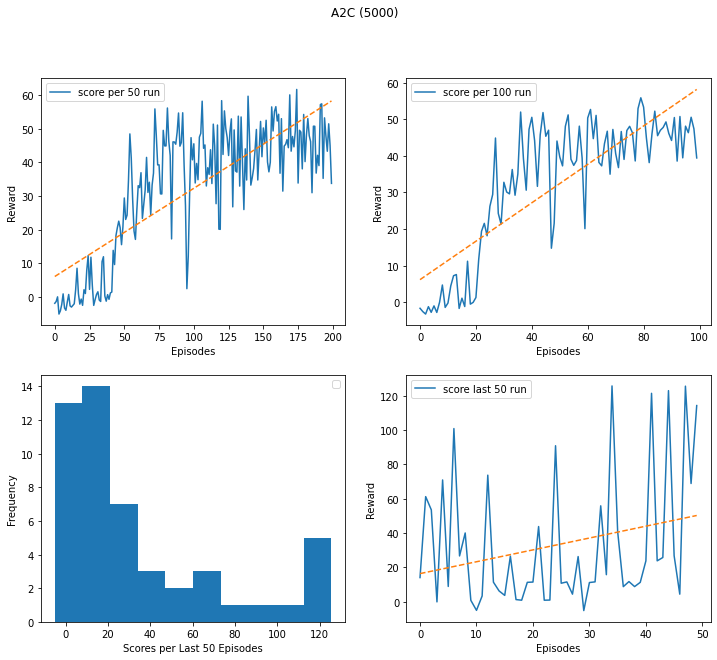

EPOCH: 4999, total reward: 114.17696231044829, timestep: 985


In [39]:
model.set_train_params(max_step=1000, plot_smooth=50)
model.train(env, 5000, show_plot=True)

In [ ]:
model.save_model()

In [14]:
import saver
saver.save_wave_model(hidden_layer, f'{save_path}/actor.pth', f'{save_path}/model.onnx')

In [18]:
import torch
import torch.nn as nn
import numpy as np
from mlagents.trainers.torch.distributions import (
    DistInstance,
    DiscreteDistInstance,
    GaussianDistribution,
    MultiCategoricalDistribution,
)


class WaveNetwork(nn.Module):
    def __init__(self, hidden_layer=512):
        super(WaveNetwork, self).__init__()
        self.dense = nn.Sequential(
            torch.nn.Linear(64, hidden_layer),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer, 2),
            torch.nn.Softmax(dim=1),
        )
        self.memory_size_vector = torch.nn.Parameter(
            torch.Tensor([0]), requires_grad=False
        )
        self.version_number = torch.nn.Parameter(torch.Tensor([3]), requires_grad=False)
        self.discrete_act_size_vector = torch.nn.Parameter(
            torch.Tensor([2]), requires_grad=False
        )

    def forward(self, obs1, obs2, action_masks):
        inp = torch.cat((obs1, obs2), dim=1)
        out = self.dense(inp)
        export_out = [
            self.version_number,
            self.memory_size_vector,
            torch.argmax(out, 1),
            self.discrete_act_size_vector,
        ]
        return tuple(export_out)


def save_wave_model(hidden_layer, load_path, save_path):
    actor = WaveNetwork(hidden_layer)
    actor.dense.load_state_dict(torch.load(load_path))
    torch.onnx.export(
        actor,
        (
            torch.Tensor(np.zeros((1, 62))),
            torch.Tensor(np.zeros((1, 2))),
            torch.Tensor(np.zeros((1, 2))),
        ),
        save_path,
        opset_version=9,
        input_names=["obs_0", "obs_1", "action_masks"],
        output_names=[
            "version_number",
            "memory_size",
            "discrete_actions",
            "discrete_action_output_shape",
        ],
        dynamic_axes={
            "obs_0": {0: "batch_size"},
            "obs_1": {0: "batch_size"},
            "discrete_actions": {0: "batch_size"},
        },
    )

save_wave_model(hidden_layer, f'{save_path}/actor.pth', f'{save_path}/model.onnx')

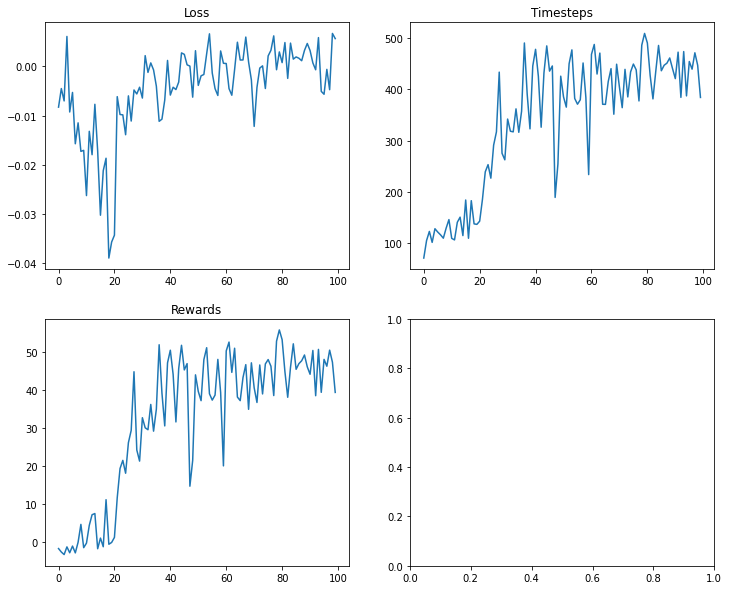

In [5]:
model.plot_train_memory(smooth=100)

In [ ]:
env = wave.WaveEnv(env_path, 20)
model.test(env)

In [5]:
model.test_avg(lambda time_scale: wave.WaveEnv(env_path, time_scale), 10, 40)

WAVE environment created.
TRY 1: 27.578163803787902, 295
WAVE environment created.
TRY 2: 113.29353512567468, 1048
WAVE environment created.
TRY 3: -7.392701272619888, 40
WAVE environment created.
TRY 4: 27.578162788646296, 295
WAVE environment created.
TRY 5: 143.58335070242174, 1131
WAVE environment created.
TRY 6: 117.58527275850065, 1047
WAVE environment created.
TRY 7: 164.5931766491849, 1382
WAVE environment created.
TRY 8: 44.004736255155876, 460
WAVE environment created.
TRY 9: 62.128610032843426, 565
WAVE environment created.
TRY 10: 109.57957596075721, 925


(80.25318828043528, 718.8)

In [ ]:
env.close()